

```
# Código Exemplo: Autoencoders
# Adaptado de https://blog.keras.io/building-autoencoders-in-keras.html
```



Autoencoder: Versão mais simples possível!

## Imports

In [1]:
import keras

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
#x_train = x_train.astype('float32')
x_test = x_test.astype('float32') / 255.
#x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [4]:
def autoencoder_create(parameters: dict):
    
    model = Sequential()
    model.add(keras.Input(shape=(784,)))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=parameters['dim'][-1-i],
                               activation=parameters['activation']
                               ))

    model.add(layers.Dense(units=parameters['dim'][0],
                           activation=parameters['activation']
                           ))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=parameters['dim'][i-parameters['intermediate']],
                               activation=parameters['activation']
                               ))

    model.add(layers.Dense(units=784, activation=parameters['out_activation']))
    
    return model

In [44]:
def train_autoencoder(model: keras.Model,
                      train_params: dict,
                      train_dataset: tuple,
                      val_dataset: tuple,
                      ):
    
    optimizer = Adam(learning_rate=train_params['learning_rate'],
                     #weight_decay=train_params['weight_decay'],
                     #decay=train_params['decay'],
                     )
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  #loss='MeanSquaredError',
                  metrics=['RootMeanSquaredError'],
                  )

    early = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=train_params['early_stop_patience'],
                          restore_best_weights=True,
                          )
    
    callback_list = [early]

    hist = model.fit(x=train_dataset[0],
                     y=train_dataset[1],
                     batch_size=256,
                     epochs=train_params['epochs'],
                     verbose=0,
                     validation_data=val_dataset,
                     callbacks=callback_list,
                     )
    
    return model, hist

In [46]:
def run_autoencoder(parameters):
    model = autoencoder_create(parameters=parameters['create'])
    model, _ = train_autoencoder(model=model,
                                 train_params=parameters['train'],
                                 train_dataset=parameters['train_dataset'],
                                 val_dataset=parameters['val_dataset'])

    score, acc = model.evaluate(x_test, x_test, verbose=0)
    print(f'\nTest accuracy: {acc}\n')
    return {'loss': score, 'status': STATUS_OK, 'model': model}

In [50]:
hp_space = {
    'create': {'dim':[784/32, 784/16, 784/8, 784/4, 784/2],
               #'intermediate': 1,
               'intermediate': ho_scope.int(hp.quniform('intermediate', low=0, high=4, q=1)),
               'activation': hp.choice('activation', ['relu', 'softmax', 'sigmoid']),
               'out_activation': 'sigmoid',
               #'out_activation': hp.choice('out_activation', ['relu', 'softmax', 'sigmoid']),
               },
    'train': {'epochs': ho_scope.int(hp.quniform('epochs',
                                                 low=10,
                                                 high=100,
                                                 q=10
                                                 )),
              'learning_rate':0.001,
              'early_stop_patience': 10,},
    'train_dataset': (x_train, x_train),
    'val_dataset': (x_test, x_test),
}
            
#ho_sample(hp_space)

In [51]:
trials = Trials()

In [52]:
best_clf = fmin(fn = run_autoencoder,
                space = hp_space,
                algo = tpe.suggest,
                max_evals = 20,
                trials = trials
                )

                                                      
Test accuracy: 0.10253582149744034

                                                                                 
Test accuracy: 0.25975513458251953

                                                                                 
Test accuracy: 0.0845143124461174

                                                                                 
Test accuracy: 0.20926032960414886

                                                                                
Test accuracy: 0.08584191650152206

                                                                                
Test accuracy: 0.20607134699821472

                                                                                
Test accuracy: 0.08244908601045609

                                                                                 
Test accuracy: 0.2597559094429016

                                                                                 
Test a

In [53]:
best_clf

{'activation': 0, 'epochs': 100.0, 'intermediate': 2.0}

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(hist.history)

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.237090,0.239667,0.157878,0.176987
1,0.138415,0.157416,0.124623,0.143248
2,0.118340,0.135067,0.111195,0.126830
3,0.108474,0.122656,0.103780,0.116610
4,0.102842,0.115030,0.099292,0.110182
5,0.099078,0.109650,0.096255,0.105684
6,0.096335,0.105588,0.093773,0.101962
7,0.094197,0.102358,0.092369,0.099574
8,0.092365,0.099477,0.090630,0.097188
9,0.090824,0.097004,0.088932,0.094196


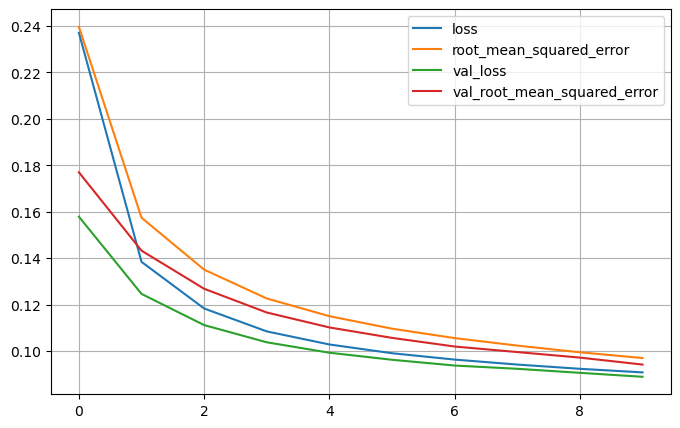

In [20]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,0.2)
plt.show()

In [ ]:
history = autoencoder.fit(x=x_train,
                          y=x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

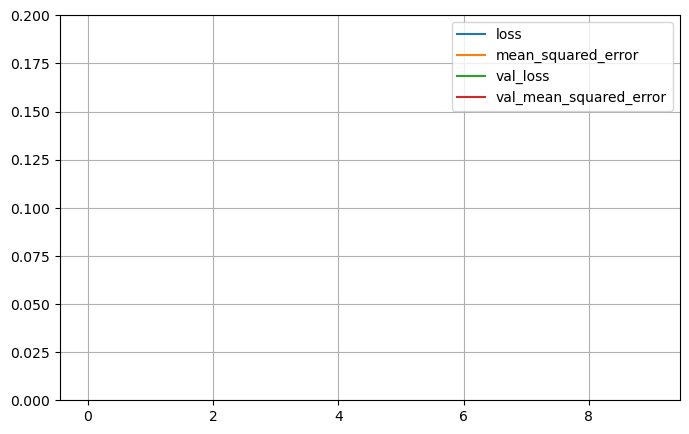

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.2)
plt.show()

In [22]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = autoencoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


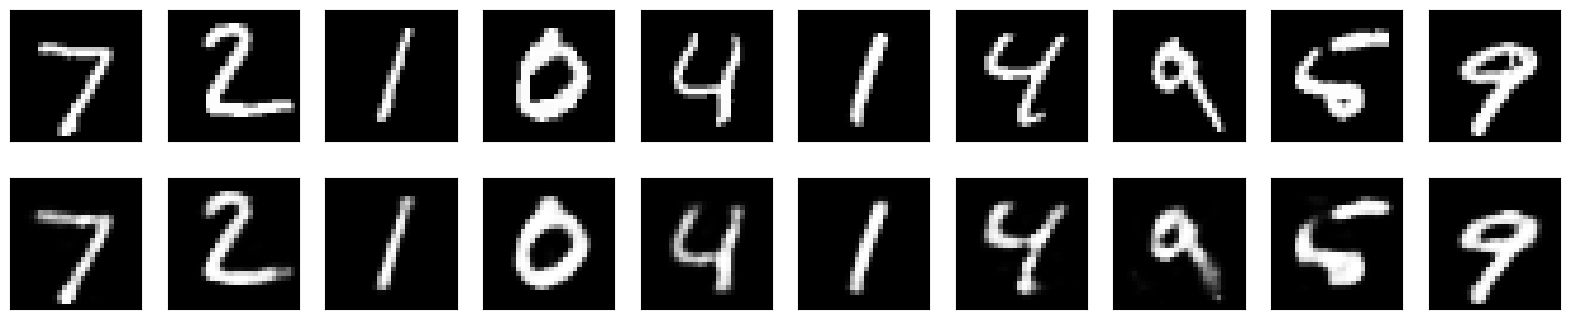

In [23]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()